<a href="https://colab.research.google.com/github/jefmabo/image-segmentation-activity/blob/main/PGC302B_Atividade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Atividade**

## Aluno: Jeferson Martins Borges
## Matrícula: 12412CCP015

**Especificação do Problema:**

O objetivo deste trabalho é analisar os métodos empregados em etapas de processamento da mídia imagem. Vamos analisar as estratégias empregadas na etapa de segmentação e extração de características das imagens. Será investigado o método mais robusto para a etapa de segmentação baseado em segmentação por similaridade. Em seguida, explorado um algoritmo de extração de características baseado em propriedades de textura. As implementações devem ocorrer em ambiente Google CoLab com a linguagem de programação Python.

$\space$
$\space$


**Dataset**

O dataset que iremos empregar neste estudo foi proposto por Ghaderzadeh, M, Aria, M, Hosseini, A, Asadi, F, Bashash, D, Abolghasemi, H. A fast and efficient CNN model for B-ALL diagnosis and its subtypes classification using peripheral blood smear images. Int J Intell Syst. 2022; 37: 5113- 5133. doi:10.1002/int.22753.

As imagens desse conjunto de dados foram preparadas no laboratório de medula óssea do Hospital Taleqani (Teerã). Esse conjunto de dados consiste em 3.256 imagens de manchas de sangue periférico (PBS) de 89 pacientes com suspeita de leucemia linfoblástica aguda (LLA), cujas amostras de sangue foram preparadas e coradas por uma equipe de laboratório. Esse conjunto de dados foi dividido em duas classes: benigna e maligna. A primeira compreende hematogônias que se assemelham muito aos casos de LLA, entretanto, essa célula precursora hematopoiética é benigna, não requer quimioterapia. O grupo de LLA com três subtipos de linfoblastos malignos: LLA pré-B inicial, pré-B e pró-B. Todas as imagens foram obtidas com uma câmera Zeiss em um microscópio com ampliação de 100 vezes e salvas como arquivos JPG. Um especialista que utilizou a ferramenta de citometria de fluxo fez a marcação do padrão ouro dos tipos e subtipos dessas células.

O dataset esta disponível no link: https://www.kaggle.com/datasets/mehradaria/leukemia/data.

$\space$
$\space$

In [11]:
pip install -r .\requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


**Segmentação**

Em nossa disciplina, apresentamos técnicas de segmentação baseadas em similiaridade (thresholding - limiarização) para processos sobre a mídia imagem.

1) Implemente um programa para segmentação de imagens baseado em limiarização adaptativa local para separação dos objetos em relação a região de fundo. Procure explorar os modelos de cores (RGB, HSV, etc) para investigar o desempenho sobre os diferentes modelos. O código desse algoritmo deve ser implementado sem usar funções disponíveis em bibliotecas da linguagem.


In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tabulate import tabulate
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import jaccard_score
from skimage.feature import graycomatrix, graycoprops

ORIGINAL_BENIGN_PATH = "./dataset/Original/Benign"
ORIGINAL_EARLY_PATH = "./dataset/Original/Early"
ORIGINAL_PRE_PATH = "./dataset/Original/Pre"
ORIGINAL_PRO_PATH = "./dataset/Original/Pro"

SEGMENTED_BENIGN_PATH = "./dataset/Segmented/Benign"
SEGMENTED_EARLY_PATH = "./dataset/Segmented/Early"
SEGMENTED_PRE_PATH = "./dataset/Segmented/Pre"
SEGMENTED_PRO_PATH = "./dataset/Segmented/Pro"

images_to_process = []
segmented_images = []

In [13]:
def get_all_images_in_folder(path):
    images_path = []

    for path, _, files in os.walk(ORIGINAL_BENIGN_PATH):
        for file in files:
            images_path.append(f"{path}/{file}")
            print()

    return images_path

In [14]:

# Função para converter a imagem RGB para escala de cinza
def rgb_to_grayscale(image):
    grayscale_image = []
    for row in image:
        grayscale_row = []
        for pixel in row:
            # Aplicando a fórmula: 0.299*R + 0.587*G + 0.114*B
            gray_value = int(0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2])
            grayscale_row.append(gray_value)
        grayscale_image.append(grayscale_row)
    return grayscale_image


In [15]:
def rgb_to_hsv(image):
    # Obter largura e altura da imagem
    width = len(image)
    height = len(image[0])

    hsv_image = []
    for y in range(height):
        hsv_row = []
        for x in range(width):
            pixel = []
            r, g, b = image[x][y]

            # # Normalizar os valores RGB para o intervalo [0, 1]
            r, g, b = r / 255.0, g / 255.0, b / 255.0
            
            # Encontrar o máximo e mínimo dos valores normalizados
            c_max = max(r, g, b)
            c_min = min(r, g, b)
            delta = c_max - c_min

            # Calcular H (Hue)
            if delta == 0:
                h = 0
            elif c_max == r:
                h = 60 * (((g - b) / delta) % 6)
            elif c_max == g:
                h = 60 * (((b - r) / delta) + 2)
            elif c_max == b:
                h = 60 * (((r - g) / delta) + 4)
            
            # Calcular S (Saturation)
            s = 0 if c_max == 0 else delta / c_max
            
            # Calcular V (Value)
            v = c_max
            
            pixel.append(h)
            pixel.append(s)
            pixel.append(v)

            hsv_row.append(pixel)
        
        hsv_image.append(hsv_row)

    return hsv_image

In [16]:
def grayscale_histogram(image):

    grayscale_image = rgb_to_grayscale(image)

    histogram = [0] * 256

    width = len(grayscale_image)
    height = len(grayscale_image[0])

    for y in range(height):
        for x in range(width):
            pixel = grayscale_image[x][y]
            histogram[pixel] += 1

    return histogram

In [17]:
# Função para aplicar limiarização adaptativa local
def adaptive_thresholding(image, window_size, c):
    height = len(image)
    width = len(image[0])
    binary_image = [[0 for _ in range(width)] for _ in range(height)]
    grayscale_image = rgb_to_grayscale(image)

    for i in range(height):
        for j in range(width):
            # Determina a janela ao redor do pixel atual
            half_window = window_size // 2
            min_i = max(i - half_window, 0)
            max_i = min(i + half_window, height - 1)
            min_j = max(j - half_window, 0)
            max_j = min(j + half_window, width - 1)

            # Calcula a média dos pixels dentro da janela
            local_sum = 0
            count = 0
            for x in range(min_i, max_i + 1):
                for y in range(min_j, max_j + 1):
                    local_sum += grayscale_image[x][y]
                    count += 1
            local_mean = local_sum // count

            # Aplica o limiar adaptativo
            if grayscale_image[i][j] > local_mean - c:
                binary_image[i][j] = 255  # Objetos
            else:
                binary_image[i][j] = 0  # Fundo

    return binary_image

In [18]:
images_to_process =  get_all_images_in_folder(ORIGINAL_BENIGN_PATH)
# images_to_process =  get_all_images_in_folder(ORIGINAL_EARLY_PATH)
# images_to_process =  get_all_images_in_folder(ORIGINAL_PRE_PATH)
# images_to_process =  get_all_images_in_folder(ORIGINAL_PRO_PATH)

segmented_images =  get_all_images_in_folder(SEGMENTED_BENIGN_PATH)
# segmented_images =  get_all_images_in_folder(SEGMENTED_EARLY_PATH)
# segmented_images =  get_all_images_in_folder(SEGMENTED_PRE_PATH)
# segmented_images =  get_all_images_in_folder(SEGMENTED_PRO_PATH)

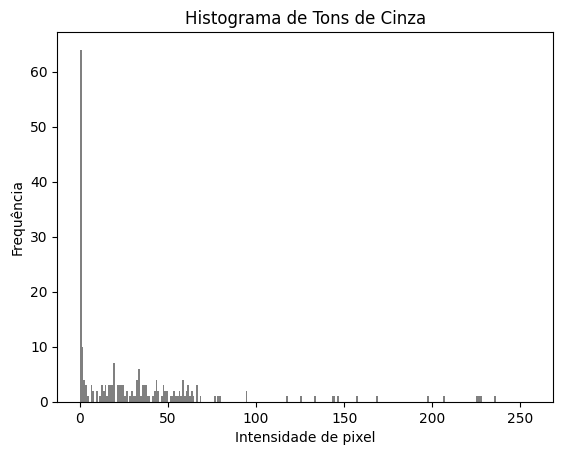

In [19]:
image = cv2.imread(images_to_process[0])
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

histogram = grayscale_histogram(image_rgb)

plt.hist(histogram, bins=256, range=(0, 256), color='gray')
plt.title('Histograma de Tons de Cinza')
plt.xlabel('Intensidade de pixel')
plt.ylabel('Frequência')
plt.show()

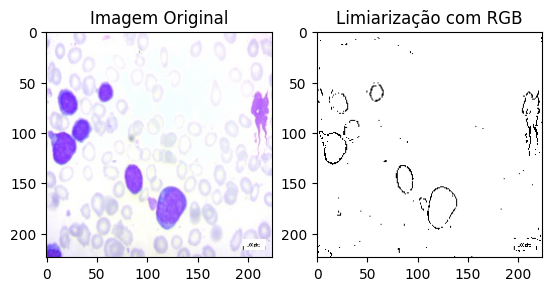

In [20]:
rgb_thresholding = adaptive_thresholding(image_rgb, window_size=3, c=10)

plt.subplot(1, 2, 1)
plt.imshow(image_rgb, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 2, 2)
plt.imshow(rgb_thresholding, cmap='gray')
plt.title('Limiarização com RGB')

plt.show()

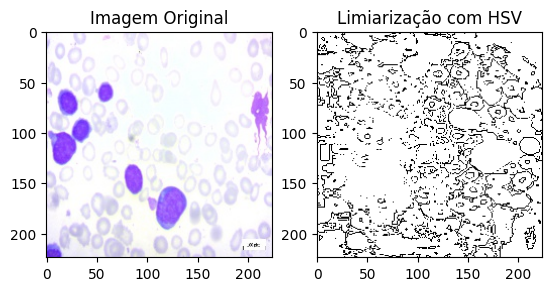

In [21]:
image_hsv = rgb_to_hsv(image_rgb)
hsv_thresholding = adaptive_thresholding(image_hsv, window_size=3, c=10)

plt.subplot(1, 2, 1)
plt.imshow(image_rgb, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 2, 2)
plt.imshow(hsv_thresholding, cmap='gray')
plt.title('Limiarização com HSV')

plt.show()


2) Em seguida, usando a biblioteca OpenCV, faça a implementação da limiarização de Otsu. Faça uma investigação sobre diferentes bibliotecas Python para processamento de imagem e escolha duas outras técnicas de limiarização disponíveis para uma comparação entre os métodos.

In [22]:
image = cv2.imread(images_to_process[0], cv2.IMREAD_GRAYSCALE)
segmented_image = cv2.imread(segmented_images[0], cv2.IMREAD_GRAYSCALE)

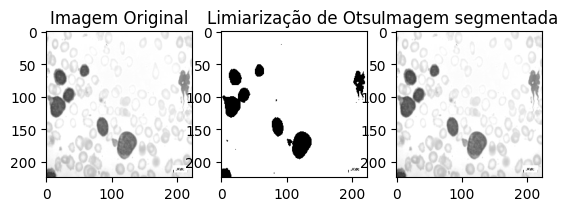

In [23]:
_, otsu_threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 3, 2)
plt.imshow(otsu_threshold, cmap='gray')
plt.title('Limiarização de Otsu')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title('Imagem segmentada')

plt.show()

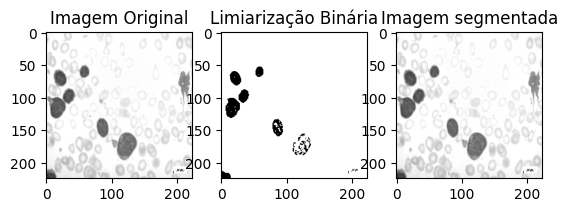

In [24]:
_, binary_threshold = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 3, 2)
plt.imshow(binary_threshold, cmap='gray')
plt.title('Limiarização Binária')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title('Imagem segmentada')

plt.show()

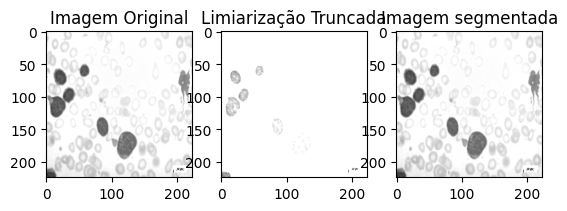

In [25]:
_, trunc_threshold = cv2.threshold(image, 127, 255, cv2.THRESH_TRUNC)

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 3, 2)
plt.imshow(trunc_threshold, cmap='gray')
plt.title('Limiarização Truncada')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title('Imagem segmentada')

plt.show()

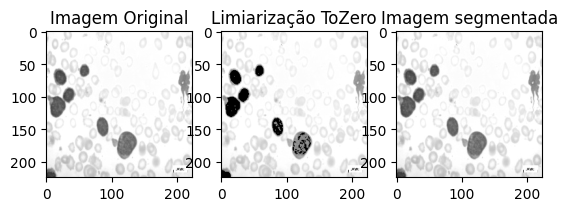

In [26]:
_, tozero_threshold = cv2.threshold(image, 127, 255, cv2.THRESH_TOZERO)

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 3, 2)
plt.imshow(tozero_threshold, cmap='gray')
plt.title('Limiarização ToZero')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title('Imagem segmentada')

plt.show()

3) Faça a aplicação das diversas técnicas sobre o conjunto de imagens proposto para o estudo.

4) Avalie os resultados em relação as máscaras disponíveis na pasta "Segmented". Obtenha os valores das métricas IoU (Intersection over Union) e coeficiente Dice usadas em segmentação.

A métrica IoU mede a sobreposição entre a área prevista e a área real:

$\text{IoU} = \frac{|A \cap B|}{|A \cup B|}$

Onde:
𝐴 - é o conjunto de pixels da segmentação prevista, 𝐵 - é o conjunto de pixels da segmentação verdadeira, ∩ - representa a interseção dos conjuntos e ∪ - representa a união dos conjuntos.

In [27]:
def iou(processed_image, ground_truth):
    # Converter para booleanos (0 e 1)
    processed_image = np.asarray(processed_image, dtype=np.bool_)
    ground_truth = np.asarray(ground_truth, dtype=np.bool_)

    # Calcular a interseção
    intersection = np.logical_and(processed_image, ground_truth)
    # Calcular a união
    union = np.logical_or(processed_image, ground_truth)
    
    # IoU = Interseção / União
    iou = np.sum(intersection) / np.sum(union)
    return iou

O coeficiente de Dice mede a similaridade entre dois conjuntos, o qual é dado por:

$\text{Dice} = \frac{2 |A \cap B|}{|A| + |B|}$

Onde: 𝐴 - é o conjunto de pixels da segmentação prevista, 𝐵 - é o conjunto de pixels da segmentação verdadeira e ∩ representa a interseção dos conjuntos.

In [28]:
def dice(processed_image, ground_truth):
    # Converter para booleanos (0 e 1)
    processed_image = np.asarray(processed_image, dtype=np.bool_)
    ground_truth = np.asarray(ground_truth, dtype=np.bool_)

    # Calcular a interseção
    intersection = np.logical_and(processed_image, ground_truth)
    
    # Dice = 2 * Interseção / (Predição + Ground Truth)
    dice = 2 * np.sum(intersection) / (np.sum(processed_image) + np.sum(ground_truth))
    return dice

In [29]:
ostu_iou_result = iou(otsu_threshold, segmented_image)
ostu_dice_result = dice(otsu_threshold, segmented_image)

binary_iou_result = iou(binary_threshold, segmented_image)
binary_dice_result = dice(binary_threshold, segmented_image)

trunc_iou_result = iou(trunc_threshold, segmented_image)
trunc_dice_result = dice(trunc_threshold, segmented_image)

tozero_iou_result = iou(tozero_threshold, segmented_image)
tozero_dice_result = dice(tozero_threshold, segmented_image)

In [30]:
data = [
    ["Otsu", ostu_iou_result, ostu_dice_result],
    ["Binary", binary_iou_result, binary_dice_result],
    ["Trunc", trunc_iou_result, trunc_dice_result],
    ["Tozero", tozero_iou_result, tozero_dice_result]
]

# Cabeçalhos da tabela
headers = ["Método", "IoU", "Coeficiente de Dice"]

# Gerar a tabela
print(tabulate(data, headers=headers, tablefmt="grid"))

+----------+----------+-----------------------+
| Método   |      IoU |   Coeficiente de Dice |
+==========+==========+=======================+
| Otsu     | 0.926778 |              0.961998 |
+----------+----------+-----------------------+
| Binary   | 0.963309 |              0.981312 |
+----------+----------+-----------------------+
| Trunc    | 1        |              1        |
+----------+----------+-----------------------+
| Tozero   | 0.963309 |              0.981312 |
+----------+----------+-----------------------+


5) Use técnicas estatísticas que quantificam o desempenho dos modelos de segmentação para uma comparação dos resultados. Para as comparações entre modelos, você pode usar os intervalos de confiança ou ANOVA. Também pode ser considerado os testes não paramétricos (Wilcoxon, Mann-Whitney).

$IC = \bar{x} \pm Z \times \frac{s}{\sqrt{n}}$


$\space$
$\space$

In [31]:
def trust_index(data, confidence=0.95):
    x = np.mean(data)
    n = len(data)
    s = np.std(data, ddof=1)
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    standart_error = s / np.sqrt(n)
    ic = z * standart_error
    return x, x - ic, x + ic


**Extração de Características**

6) Crie um programa que leia as imagens do dataset sem segmentação e calcule a matriz de coocorrência numa representação de 256 níveis de intensidades. Como as imagens estão em RGB faça a conversão para níveis de cinza. Use as orientações de 0, 45, 90 e 135 graus com d = 1, d = 2, d = 3 e d = 4. Calcule a média e o desvio padrão das matrizes.

In [32]:
distancies = [1, 2, 3, 4]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
glcm_images = []
glcm_ground_thruths = []

for i in range(len(images_to_process)):
    image = cv2.imread(images_to_process[i], cv2.IMREAD_GRAYSCALE)
    ground_thruth = cv2.imread(segmented_images[i], cv2.IMREAD_GRAYSCALE)

    glcm_image = graycomatrix(image, distances=distancies, angles=angles, levels=256, symmetric=True, normed=True)
    glcm_ground_thruth = graycomatrix(ground_thruth, distances=distancies, angles=angles, levels=256, symmetric=True, normed=True)

    glcm_images.append(glcm_image)
    glcm_ground_thruths.append(glcm_ground_thruth)

7) Utilize as matrizes de coocorrência e calcule 5 principais descritores propostos por Haralick.

In [33]:
def haralick_descriptors(glcm):
    contrast = graycoprops(glcm, prop='contrast')[0, 0]
    energy = graycoprops(glcm, prop='energy')[0, 0]
    correlation = graycoprops(glcm, prop='correlation')[0, 0]
    homogeneity = graycoprops(glcm, prop='homogeneity')[0, 0]
    glcm_norm = glcm / np.sum(glcm)
    entropy = -np.sum(glcm_norm * np.log2(glcm_norm + np.finfo(float).eps))

    return [contrast, energy, correlation, homogeneity, entropy]    

8) Faça uma análise de similaridade entre as classes investigadas por meio de características extraídas com os descritores e a variação de parametrização. Para essa análise, use a similaridade de Jaccard e o coeficiente de correlação de Pearson.

A similaridade de Jaccard pode ser aplicada diretamente se você tratar os descritores de Haralick como conjuntos de valores binarizados ou discreto:

$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$

onde: ∣A∩B∣∣A∩B∣ é o tamanho da interseção entre AA e BB, e ∣A∪B∣∣A∪B∣ é o tamanho da união dos conjuntos AA e BB.

In [34]:
def jaccard_similarity(vector1, vector2):
    intersection = np.sum(np.minimum(vector1, vector2))
    union = np.sum(np.maximum(vector1, vector2))
    result = intersection / union if union != 0 else 0
    print(result)
    return result

coeficiente de correlação de Pearson:

$ r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}$

onde, x e y são as duas variáveis, n é o número de observações, x̄ e ȳ são as médias de x e y, respectivamente.

In [35]:
def pearson_correlation(vetor1, vetor2):
    coefficients = []
    p_values = []
    for i in range(len(vetor1)):
        coef, p_valor = pearsonr([vetor1[i]], [vetor2[i]])
        coefficients.append(coef)
        p_values.append(p_valor)
    return coefficients, p_values

In [37]:
image_contrast = []
image_energy = []
image_correlation = []
image_homogeneity = []
image_entropy = []

ground_thruth_contrast = []
ground_thruth_energy = []
ground_thruth_correlation = []
ground_thruth_homogeneity = []
ground_thruth_entropy = []

jaccard_similarities = []
jaccard_scores = []

pearson_coefficients = []
pearson_values = []

for i in range(len(glcm_images)):
    glcm_image = glcm_images[i]
    glcm_ground_thruth = glcm_ground_thruths[i]

    haralick_image = haralick_descriptors(glcm_image)
    haralick_ground_thruth = haralick_descriptors(glcm_ground_thruth)

    haralick_image_bin = np.array([1 if valor > 0.5 else 0 for valor in haralick_image])
    haralick_ground_thruth_bin = np.array([1 if valor > 0.5 else 0 for valor in haralick_ground_thruth])

    jaccard = jaccard_similarity(haralick_image_bin, haralick_ground_thruth_bin)

    # jaccard_s = jaccard_score(haralick_image_bin, haralick_ground_thruth_bin)

    # print(jaccard)
    # print(jaccard_s)

    print(len(haralick_image))
    print(len(haralick_ground_thruth))

    pearson_coefficient, pearson_value = pearson_correlation(haralick_image, haralick_ground_thruth)

    image_contrast.append(haralick_image[0])
    image_energy.append(haralick_image[1])
    image_correlation.append(haralick_image[2])
    image_homogeneity.append(haralick_image[3])
    image_entropy.append(haralick_image[4])

    ground_thruth_contrast.append(haralick_ground_thruth[0])
    ground_thruth_energy.append(haralick_ground_thruth[1])
    ground_thruth_correlation.append(haralick_ground_thruth[2])
    ground_thruth_homogeneity.append(haralick_ground_thruth[3])
    ground_thruth_entropy.append(haralick_ground_thruth[4])

    jaccard_similarities.append(jaccard)
    # jaccard_scores.append(jaccard_s)

    pearson_coefficients.append(pearson_coefficient)
    pearson_values.append(pearson_value)
    

1.0
[1 0 1 0 1]
[1 0 1 0 1]
5
5


ValueError: x and y must have length at least 2.

9) Discuta os resultados e as observações em relação as variações de parâmetros e a representação pela técnica para as classes investigadas.

10) Repita esses experimentos sobre as imagens segmentadas com a melhor resultado da técnica de segmentação obtida na etapa 5). Avalie o comportamento dos descritores com informações segmentadas. Faça discussões semelhantes as observações obtidas na questão 9) com as imagens segmentadas.


$\space$
$\space$

**Entrega**


O trabalho deve ser submetido por meio da plataforma Microsoft Teams.

Data de entrega: **23/10/2024**

Essa atividade pode ser realizada em grupos de dois estudantes, os quais deverão submeter o relatório pela plataforma Teams.

A entrega do trabalho deve conter os seguintes itens:
* codigo-fonte: o arquivo final deve estar no formato .zip ou no formato tgz, contendo todos os programas ou dados necessarios para sua execução. Também deve ter um cabeçalho com os dados dos estudantes (Nome e Matrícula).
* relatorio: deve conter uma descrição dos algoritmos e das estruturas de dados, considerações adotadas na solução do problema, testes executados, eventuais limitações ou situações especiais não explorada pelo programa.